# Time-series Anomaly Detection


This demo shows how to use a novel SLS (Streaming Least Squares) anomaly detection algorithm and how it performs.

Its builded on http://nbviewer.jupyter.org/github/MSRDL/TSA/blob/master/sls_demo.ipynb

Check out this repository to know more: https://github.com/MSRDL/TSA

## Imports

In [19]:
%pylab inline
#rcParams['figure.figsize'] = [20, 7]
import pandas as pd
from influxdb import DataFrameClient

Populating the interactive namespace from numpy and matplotlib


In [20]:
from anomaly_detection import detect_anomalies

## Define influxdb query function
Get ticker data from our db. With DataFrameClient we easily get pd as return.

In [50]:
def get_ticker_data(exchange, symbol):
    '''Get an price data for past hour from the storage
    and return it as pandas dataframe.'''
    client = DataFrameClient('18.182.117.179',8086,'nightly','','')
    myquery = """SELECT last("ask") AS "ask", last("bid") AS "bid" 
                     FROM "TKG"."autogen"."ticker_data" 
                     WHERE time > now() - 601m
                     AND time < now() - 1m
                     AND "exchange"='{}' 
                     AND "ticker"='{}' 
                     GROUP BY time(1s) 
                     FILL(previous)""".format(exchange, symbol) # 'binance', 'BTC/USDT'
    raw_data = client.query(myquery)
    ticker_data = pd.DataFrame(raw_data['ticker_data'])
    return ticker_data

## Pull data to construct derivative

Lets define our settings.

In [51]:
exchange1 = 'binance'
exchange2 = 'kucoin'
symbol = 'BTC/USDT'

And call our function to get data

In [52]:
btc_usdt_binance = get_ticker_data(exchange1,symbol)
btc_usdt_kucoin = get_ticker_data(exchange2, symbol)

Lets explore what we get.

In [53]:
btc_usdt_binance.head()

ask      bid
2018-12-24 01:16:58+00:00  4121.94  4120.06
2018-12-24 01:16:59+00:00  4121.94  4120.06
2018-12-24 01:17:00+00:00  4121.92  4120.07
2018-12-24 01:17:01+00:00  4120.06  4120.00
2018-12-24 01:17:02+00:00  4121.96  4120.10

Now letts build a new table with mixed data.

In [54]:
mixed_data = pd.concat([btc_usdt_binance, btc_usdt_kucoin], axis=1).dropna()


In [55]:
mixed_data.columns = ['binance_ask','binance_bid','kucoin_ask','kucoin_bid']
mixed_data.head()

binance_ask  binance_bid   kucoin_ask   kucoin_bid
2018-12-24 01:17:04+00:00      4121.96      4120.12  4126.269202  4120.089068
2018-12-24 01:17:05+00:00      4121.93      4120.11  4126.269202  4120.089068
2018-12-24 01:17:06+00:00      4121.93      4120.12  4129.299797  4128.351534
2018-12-24 01:17:07+00:00      4121.90      4120.13  4126.269202  4120.089068
2018-12-24 01:17:08+00:00      4121.90      4120.15  4126.269202  4120.089068

In [56]:
mixed_data['bin_ask_kuc_bid'] = mixed_data['binance_ask'] - mixed_data['kucoin_bid']
mixed_data['bin_bid_kuc_ask'] = mixed_data['binance_bid'] - mixed_data['kucoin_ask']
mixed_data['mean'] = (mixed_data['bin_ask_kuc_bid'] + mixed_data['bin_bid_kuc_ask'])/2
mixed_data['mean_ma'] = mixed_data['mean'].rolling(100).mean()
mixed_data['mmdiff'] = mixed_data['mean_ma'] - mixed_data['mean']
mixed_data.tail()

binance_ask  binance_bid   kucoin_ask   kucoin_bid  \
2018-12-24 11:16:54+00:00      4087.15      4085.00  4082.000000  4081.860585   
2018-12-24 11:16:55+00:00      4087.10      4085.02  4082.000000  4081.860585   
2018-12-24 11:16:56+00:00      4087.08      4085.01  4082.000000  4081.860585   
2018-12-24 11:16:57+00:00      4087.08      4085.02  4082.000000  4081.860585   
2018-12-24 11:16:58+00:00      4087.08      4085.04  4085.156518  4082.097365   

                           bin_ask_kuc_bid  bin_bid_kuc_ask      mean  \
2018-12-24 11:16:54+00:00         5.289415         3.000000  4.144708   
2018-12-24 11:16:55+00:00         5.239415         3.020000  4.129707   
2018-12-24 11:16:56+00:00         5.219415         3.010000  4.114708   
2018-12-24 11:16:57+00:00         5.219415         3.020000  4.119708   
2018-12-24 11:16:58+00:00         4.982635        -0.116518  2.433059   

                            mean_ma    mmdiff  
2018-12-24 11:16:54+00:00 -0.708232 -4.852939  
2018-12-24 11:16:55+00:00 -0.634517 -4.764224  
2018-12-24 11:16:56+00:00 -0.557152 -4.671859  
2018-12-24 11:16:57+00:00 -0.475487 -4.595195  
2018-12-24 11:16:58+00:00 -0.397742 -2.830800

Lets try try some basic statistic on our data

In [57]:
mixed_data['mmdiff'].describe(percentiles=[.005,.01,.99,.995])

count    35896.000000
mean        -0.004421
std          2.288702
min        -12.744991
0.5%        -7.982843
1%          -6.622595
50%         -0.006242
99%          6.160410
99.5%        7.225512
max         13.798836
Name: mmdiff, dtype: float64

In [73]:
lag = 20
num_anomalies=10
num_levels=10

In [74]:
anomalies, thresholds = detect_anomalies(data, lag, num_anomalies, visualize=False)

In [75]:
from IPython.display import display

In [76]:
display(anomalies)

level                      start                        end      score
0      5  2018-12-24 10:18:36+00:00  2018-12-24 10:18:55+00:00  18.471083
1      4  2018-12-24 09:15:02+00:00  2018-12-24 09:15:21+00:00  17.701571
2      3  2018-12-24 06:19:58+00:00  2018-12-24 06:20:17+00:00  16.182954
3      3  2018-12-24 04:00:53+00:00  2018-12-24 04:01:12+00:00  15.762952
4      3  2018-12-24 02:27:43+00:00  2018-12-24 02:28:02+00:00  15.696834
5      3  2018-12-24 10:31:17+00:00  2018-12-24 10:31:36+00:00  15.472091
6      2  2018-12-24 01:59:51+00:00  2018-12-24 02:00:10+00:00  14.698394
7      1  2018-12-24 01:39:51+00:00  2018-12-24 01:40:10+00:00  14.188137
8      1  2018-12-24 10:18:12+00:00  2018-12-24 10:18:31+00:00  13.928219
9      1  2018-12-24 02:29:55+00:00  2018-12-24 02:30:14+00:00  13.798084

In [77]:
display(thresholds)

[18.470082874296686,
 17.70057075681527,
 15.471091063530626,
 14.697394447432846,
 13.7970837956144]

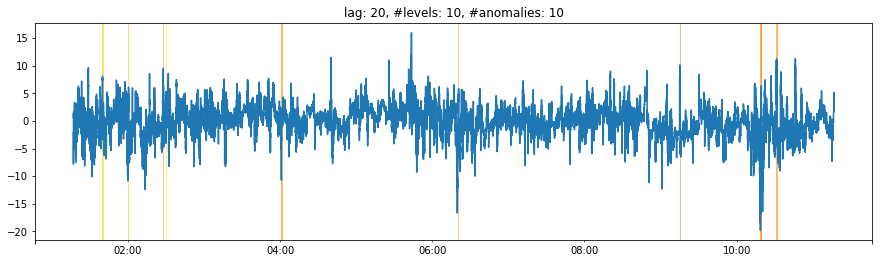

In [78]:
rcParams['figure.figsize'] = [15, 4]
data.plot(title='lag: {0}, #levels: {1}, #anomalies: {2}'.format(lag, num_levels, num_anomalies))

for anomaly in anomalies.values:
    plt.axvspan(anomaly[1],
                anomaly[2],
                color=plt.cm.jet(0.65 + float(anomaly[0]) / num_levels / 3),
                alpha=0.5)

In the above, SLS was able to detect spikes in the series. The same algorithm can be used for detecting dips as well while rinning in real-time. To simulate that lets check the data from last 1 min.

In [84]:
last_data = data.tail(600)

level                      start                        end     score
0      1  2018-12-24 11:13:51+00:00  2018-12-24 11:14:00+00:00  4.484071

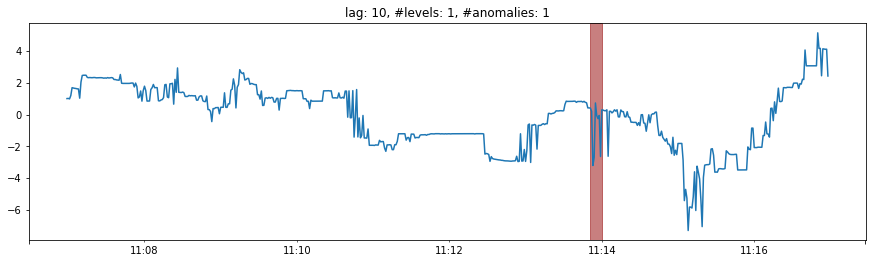

In [112]:
anomalies, thresholds = detect_anomalies(last_data, lag=10, num_anomalies=1)

## Model deployment for real-time anomaly detection

The demo here is for evaluting the effectiveness of the algorithm on historical data. To deploy the model for real-time detection on streaming data, follow this C++ API.

1. Instantiate the anomaly detector from the model file.
2. Then, for each new counter value, call Predict to get the alert level as well as the trend and anomaly score.

## Bulk Predict

We also provide a bulk predict API for handling multiple signals in parallel (via OpenMP).